APLICA CAPTUM SOBRE OTRO MODELO ENTRENADO CON EL DATASET TITANIC (NO EL NUESTRO).  
Precision del 82%.

In [1]:
# %pip install torch
# %pip install captum

In [1]:
# Initial imports
import numpy as np

import torch

from captum.attr import IntegratedGradients
from captum.attr import LayerConductance
from captum.attr import NeuronConductance

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pandas as pd

c:\Users\cpt\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Update path to dataset here.
dataset_path = "titanic.csv"

In [3]:
# Read dataset from csv file.
titanic_data = pd.read_csv(dataset_path)

In [4]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Con los datos cargados, ahora preprocesamos los datos convirtiendo algunas características categóricas como el género, la ubicación del embarque y la clase de pasajero en codificaciones únicas (columnas de características separadas para cada clase con 0/1). 
También eliminamos algunas características que son más difíciles de analizar, como el nombre, y completamos los valores faltantes en la edad y la tarifa con los valores promedio.

In [5]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['Sex']),
                          pd.get_dummies(titanic_data['Embarked'],prefix="Embark"),
                          pd.get_dummies(titanic_data['Pclass'],prefix="Class")], axis=1)

titanic_data["Age"] = titanic_data["Age"].fillna(titanic_data["Age"].mean())
titanic_data["Fare"] = titanic_data["Fare"].fillna(titanic_data["Fare"].mean())

titanic_data = titanic_data.drop(['PassengerId', 'Name','Ticket','Sex','Embarked','Pclass', 'Cabin'], axis=1)

In [8]:
titanic_data.head()

,Survived,Age,SibSp,Parch,Fare,female,male,Embark_C,Embark_Q,Embark_S,Class_1,Class_2,Class_3
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [12]:
titanic_data.head()

,survived,age,sibsp,parch,fare,female,male,embark_C,embark_Q,embark_S,class_1,class_2,class_3
0,1,29.00,0,0,211.3375,1,0,0,0,1,1,0,0
1,1,0.92,1,2,151.5500,0,1,0,0,1,1,0,0
2,0,2.00,1,2,151.5500,1,0,0,0,1,1,0,0
3,0,30.00,1,2,151.5500,0,1,0,0,1,1,0,0
4,0,25.00,1,2,151.5500,1,0,0,0,1,1,0,0


Después del procesamiento, las características que tenemos son:

Age  - Edad del Pasajero  
Sibsp - Número de hermanos/cónyuges a bordo  
Parch - Número de padres/hijos a bordo  
Fare  - Importe de tarifa pagado en libras esterlinas  
Female  - Variable binaria que indica si el pasajero es mujer  
Male  - Variable binaria que indica si el pasajero es hombre  
EmbarkC - Variable binaria que indica si el pasajero se embarcó en Cherburgo  
EmbarkQ: variable binaria que indica si el pasajero se embarcó en Queenstown  
EmbarkS - Variable binaria que indica si el pasajero se embarcó en Southampton  
Class1 - Variable binaria que indica si el pasajero estaba en primera clase  
Class2 - Variable binaria que indica si el pasajero estaba en segunda clase  
Class3 - Variable binaria que indica si el pasajero estaba en tercera clase  

Ahora convertimos los datos en matrices numpy y separamos los conjuntos de entrenamiento y prueba.

In [9]:
# Set random seed for reproducibility.
np.random.seed(131254)

# Convert features and labels to numpy arrays.
labels = titanic_data["Survived"].to_numpy()
titanic_data = titanic_data.drop(['Survived'], axis=1)
feature_names = list(titanic_data.columns)
data = titanic_data.to_numpy()

# Separate training and test sets using 
train_indices = np.random.choice(len(labels), int(0.7*len(labels)), replace=False)
test_indices = list(set(range(len(labels))) - set(train_indices))
train_features = data[train_indices]
train_labels = labels[train_indices]
test_features = data[test_indices]
test_labels = labels[test_indices]

Ahora estamos listos para definir la arquitectura de la red neuronal que usaremos para la tarea.  Hemos definido una arquitectura simple utilizando 2 capas ocultas, la primera con 12 unidades ocultas y la segunda con 8 unidades ocultas, cada una con no linealidad sigmoide.  La capa final realiza una operación softmax y tiene 2 unidades, correspondientes a las salidas de sobrevivido (1) o no sobrevivido (0).

In [10]:
import torch
import torch.nn as nn
torch.manual_seed(1)  # Set seed for reproducibility.

class TitanicSimpleNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 12)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(12, 8)
        self.sigmoid2 = nn.Sigmoid()
        self.linear3 = nn.Linear(8, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        lin1_out = self.linear1(x)
        sigmoid_out1 = self.sigmoid1(lin1_out)
        sigmoid_out2 = self.sigmoid2(self.linear2(sigmoid_out1))
        return self.softmax(self.linear3(sigmoid_out2))

Podemos usar un modelo previamente entrenado o entrenar la red usando los datos de entrenamiento para 200 épocas. Tenga en cuenta que los resultados de los pasos posteriores pueden no coincidir si se vuelve a entrenar. 

In [11]:
net = TitanicSimpleNNModel()
USE_PRETRAINED_MODEL = False

if USE_PRETRAINED_MODEL:
    net.load_state_dict(torch.load('titanic_model.pt'))
    print("Model Loaded!")

    #input_tensor = torch.from_numpy(train_features).type(torch.BoolTensor)  # Para convertir datos booleanos
    #input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor) # Para convertir datos enteros

    input_tensor = torch.from_numpy(train_features.astype(float)).type(torch.FloatTensor) # Para convertir datos enteros y booleanos
    label_tensor = torch.from_numpy(train_labels)
else:
    criterion = nn.CrossEntropyLoss()
    num_epochs = 200

    optimizer = torch.optim.Adam(net.parameters(), lr=0.1)

    # input_tensor = torch.from_numpy(train_features).type(torch.FloatTensor)

    input_tensor = torch.from_numpy(train_features.astype(float)).type(torch.FloatTensor) # Para convertir datos enteros y booleanos
    label_tensor = torch.from_numpy(train_labels)

    for epoch in range(num_epochs):    
        output = net(input_tensor)
        loss = criterion(output, label_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if epoch % 20 == 0:
            print ('Epoch {}/{} => Loss: {:.2f}'.format(epoch+1, num_epochs, loss.item()))

    torch.save(net.state_dict(), 'titanic_model.pt')

Epoch 1/200 => Loss: 0.70
Epoch 21/200 => Loss: 0.55
Epoch 41/200 => Loss: 0.50
Epoch 61/200 => Loss: 0.48
Epoch 81/200 => Loss: 0.48
Epoch 101/200 => Loss: 0.48
Epoch 121/200 => Loss: 0.47
Epoch 141/200 => Loss: 0.48
Epoch 161/200 => Loss: 0.47
Epoch 181/200 => Loss: 0.48


Ahora podemos evaluar las precisiones de entrenamiento y prueba de nuestro modelo.

In [13]:
out_probs = net(input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Train Accuracy:", sum(out_classes == train_labels) / len(train_labels))

Train Accuracy: 0.8426966292134831


In [16]:
# test_input_tensor = torch.from_numpy(test_features).type(torch.FloatTensor)
test_input_tensor = torch.from_numpy(test_features.astype(float)).type(torch.FloatTensor) # Para convertir datos enteros y booleanos

out_probs = net(test_input_tensor).detach().numpy()
out_classes = np.argmax(out_probs, axis=1)
print("Test Accuracy:", sum(out_classes == test_labels) / len(test_labels))

Test Accuracy: 0.8171641791044776


Más allá de solo considerar la precisión del clasificador, hay muchas preguntas importantes para comprender cómo funciona el modelo y su decisión, que es el propósito de Captum, ayudar a que las redes neuronales en PyTorch sean más interpretables.

La primera pregunta que podemos hacernos es ¿cuáles de las características fueron realmente importantes para el modelo para llegar a esta decisión? Este es el primer componente principal de Captum, la capacidad de obtener atribuciones de funciones. Para este ejemplo, aplicaremos Integrated Gradients, que es uno de los métodos de Feature Attribution incluidos en Captum. 

Para aplicar gradientes integrados, primero creamos un objeto IntegratedGradients, proporcionando el objeto modelo.

In [14]:
ig = IntegratedGradients(net)

Para calcular los gradientes integrados, usamos el método de atributos del objeto IntegratedGradients. El método toma tensor(es) de ejemplos de entrada (que coinciden con la función de avance del modelo) y devuelve las atribuciones de entrada para los ejemplos dados. Para una red con múltiples salidas, también se debe proporcionar un índice objetivo, definiendo el índice de la salida para el cual se calculan los gradientes. Para este ejemplo, proporcionamos target = 1, correspondiente a la supervivencia.

El tensor de entrada provisto debe requerir grad, por lo que llamamos a require_grad_ en el tensor. El método de atributos también toma una línea de base, que es el punto de partida desde el cual se integran los degradados. El valor predeterminado es solo el tensor 0, que es una línea base/predeterminada razonable para esta tarea.

Los valores devueltos por el método de atributo son las atribuciones, que coinciden con el tamaño de las entradas dadas, y delta, que aproxima el error entre la integral aproximada y la integral verdadera.

In [17]:
test_input_tensor.requires_grad_()
attr, delta = ig.attribute(test_input_tensor,target=1, return_convergence_delta=True)
attr = attr.detach().numpy()

Para comprender estas atribuciones, primero podemos promediarlas en todas las entradas e imprimir/visualizar la atribución promedio para cada característica.

Average Feature Importances
Age :  -0.948
SibSp :  -0.034
Parch :  -0.015
Fare :  0.353
female :  0.268
male :  -0.374
Embark_C :  0.045
Embark_Q :  0.038
Embark_S :  -0.004
Class_1 :  0.070
Class_2 :  0.112
Class_3 :  -0.243


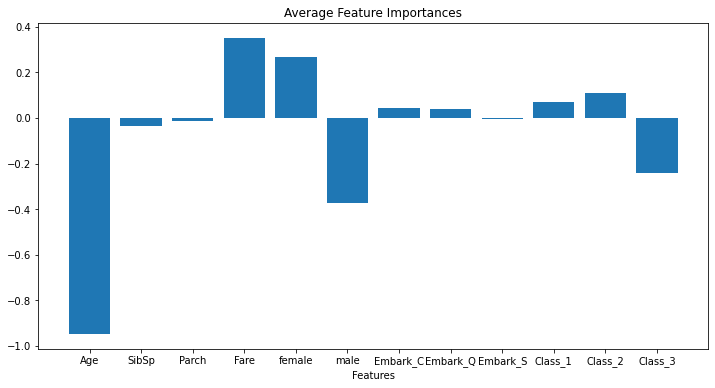

In [18]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, importances, title="Average Feature Importances", plot=True, axis_title="Features"):
    print(title)
    for i in range(len(feature_names)):
        print(feature_names[i], ": ", '%.3f'%(importances[i]))
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(12,6))
        plt.bar(x_pos, importances, align='center')
        plt.xticks(x_pos, feature_names, wrap=True)
        plt.xlabel(axis_title)
        plt.title(title)
visualize_importances(feature_names, np.mean(attr, axis=0))

A partir de la información de atribución de características, obtenemos algunas ideas interesantes sobre la importancia de varias características. Vemos que las características más fuertes parecen ser la edad (especialmente) y el sexo masculino, que se correlacionan negativamente con la supervivencia. Embarcarse en Southampton y el número de padres/hijos parecen ser características menos importantes en general.

Una cosa importante a tener en cuenta es que las atribuciones promedio sobre el conjunto de prueba no necesariamente capturan toda la información sobre la importancia de las funciones. También deberíamos mirar la distribución de atribuciones para cada función. Es posible que las características tengan atribuciones muy diferentes para diferentes ejemplos en el conjunto de datos.

Por ejemplo, podemos visualizar la distribución de atribuciones para sibsp, el número de hermanos/cónyuges.

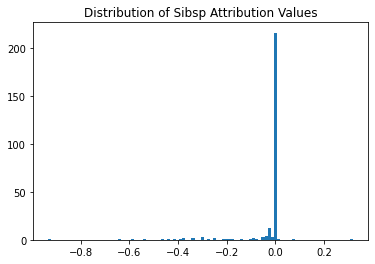

In [20]:
plt.hist(attr[:,1], 100);
plt.title("Distribution of Sibsp Attribution Values");

Notamos que la gran mayoría de los ejemplos tienen un valor de atribución de 0 para sibsp, lo que probablemente corresponde a tener un valor de 0 para la función (IntegratedGradients proporcionaría una atribución de 0 cuando el valor de la función coincida con la línea base de 0). Más significativamente, vemos que aunque el promedio parece menor en magnitud en el gráfico anterior, hay una pequeña cantidad de ejemplos con atribuciones negativas para esta característica.

Para comprender mejor esto, podemos agrupar los ejemplos por el valor de la función sibsp y trazar la atribución promedio de la función. En la siguiente gráfica, el tamaño del punto es proporcional al número de ejemplos con ese valor.

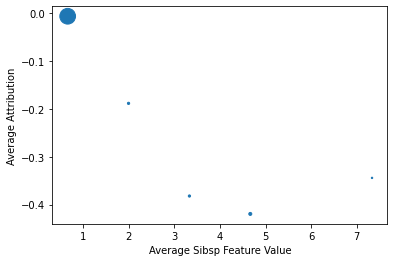

In [21]:
bin_means, bin_edges, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='mean', bins=6)
bin_count, _, _ = stats.binned_statistic(test_features[:,1], attr[:,1], statistic='count', bins=6)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2
plt.scatter(bin_centers, bin_means, s=bin_count)
plt.xlabel("Average Sibsp Feature Value");
plt.ylabel("Average Attribution");

Vemos que las atribuciones de mayor magnitud corresponden a los ejemplos con valores de característica Sibsp más grandes, lo que sugiere que la característica tiene un mayor impacto en la predicción de estos ejemplos. Dado que hay una cantidad sustancialmente menor de estos ejemplos (en comparación con aquellos con un valor de característica de 0), la atribución promedio no captura completamente este efecto.

Ahora que tenemos una mejor comprensión de la importancia de las diferentes características de entrada, la siguiente pregunta que podemos hacer con respecto a la función de la red neuronal es cómo las diferentes neuronas en cada capa trabajan juntas para alcanzar la predicción. Por ejemplo, en nuestra salida de la primera capa oculta que contiene 12 unidades, ¿se usan todas las unidades para la predicción? ¿Algunas unidades aprenden características correlacionadas positivamente con la supervivencia mientras que otras aprenden características correlacionadas negativamente con la supervivencia?

Esto nos lleva al segundo tipo de atribuciones disponibles en Captum, Layer Attributions. Las atribuciones de capa nos permiten comprender la importancia de todas las neuronas en la salida de una capa en particular. Para este ejemplo, usaremos Layer Conductance, uno de los métodos de Layer Attribution en Captum, que es una extensión de Integrated Gradients aplicada a neuronas ocultas. 

Para usar Layer Conductance, creamos un objeto LayerConductance pasando el modelo y el módulo (capa) cuya salida nos gustaría comprender. En este caso, elegimos net.sigmoid1, la salida de la primera capa oculta.

In [22]:
cond = LayerConductance(net, net.sigmoid1)

Ahora podemos obtener los valores de conductancia para todos los ejemplos de prueba llamando al atributo en el objeto LayerConductance. LayerConductance también requiere un índice objetivo para redes con múltiples salidas, definiendo el índice de la salida para el cual se calculan los gradientes. De manera similar a las atribuciones de características, proporcionamos el objetivo = 1, correspondiente a la supervivencia. LayerConductance también utiliza una línea base, pero nosotros simplemente usamos la línea base cero predeterminada como en los degradados integrados.

In [23]:
cond_vals = cond.attribute(test_input_tensor,target=1)
cond_vals = cond_vals.detach().numpy()

Podemos comenzar visualizando la conductancia promedio para cada neurona.

Average Neuron Importances
0 :  0.010
1 :  -0.022
2 :  0.020
3 :  0.007
4 :  -0.298
5 :  -0.043
6 :  -0.295
7 :  -0.032
8 :  0.021
9 :  -0.022
10 :  -0.087
11 :  0.017


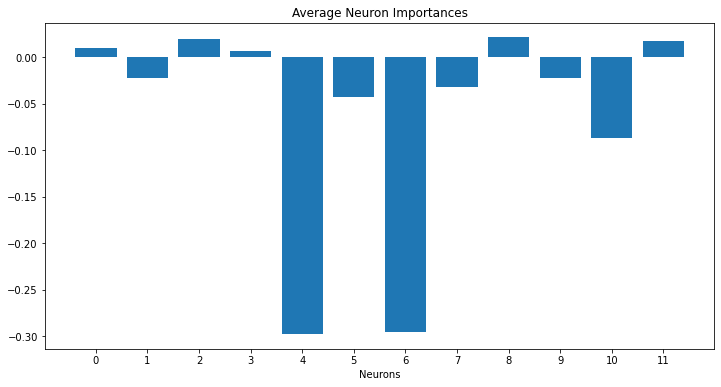

In [32]:
visualize_importances(range(12),np.mean(cond_vals, axis=0),title="Average Neuron Importances", axis_title="Neurons")

También podemos observar la distribución de las atribuciones de cada neurona. A continuación, observamos las distribuciones de las neuronas 0 y 3, y podemos confirmar que sus distribuciones de atribución son muy cercanas a 0, lo que sugiere que no están aprendiendo características sustanciales.

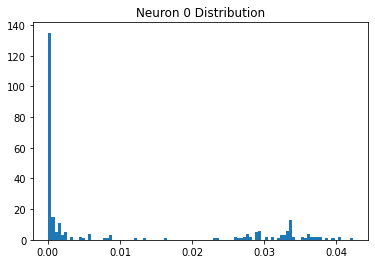

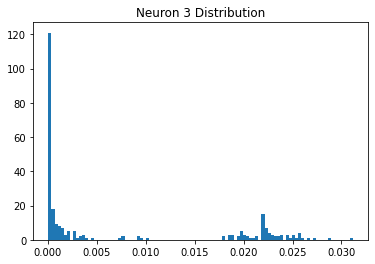

In [42]:
plt.hist(cond_vals[:,0], 100);
plt.title("Neuron 0 Distribution")
plt.figure()
plt.hist(cond_vals[:,3], 100);
plt.title("Neuron 3 Distribution");

Ahora, podemos observar las distribuciones de las neuronas 4 y 6, que parecen estar aprendiendo características fuertes negativamente correlacionadas con la supervivencia.

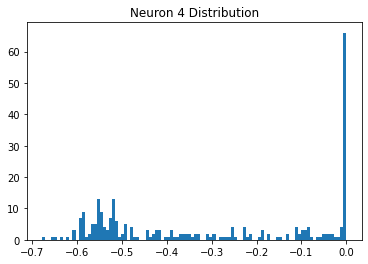

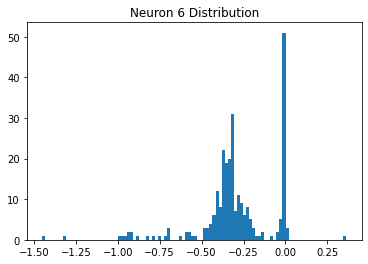

In [43]:
plt.hist(cond_vals[:,4], 100);
plt.title("Neuron 4 Distribution")
plt.figure()
plt.hist(cond_vals[:,6], 100);
plt.title("Neuron 6 Distribution");

Hemos identificado que algunas de las neuronas no están aprendiendo características importantes, mientras que otras sí. ¿Podemos ahora entender qué está mirando cada una de estas importantes neuronas en la entrada? Por ejemplo, ¿identifican características diferentes en la entrada o similares?

Para responder a estas preguntas, podemos aplicar el tercer tipo de atribuciones disponibles en Captum, Neuron Attributions. Esto nos permite comprender qué partes de la entrada contribuyen a activar una neurona de entrada en particular. Para este ejemplo, aplicaremos Neuron Conductance, que divide el valor de conductancia total de la neurona en la contribución de cada característica de entrada individual.

Para usar Neuron Conductance, creamos un objeto NeuronConductance, de manera análoga a Conductance, pasando el modelo y el módulo (capa) cuya salida nos gustaría entender, en este caso, net.sigmoid1, como antes.

In [41]:
neuron_cond = NeuronConductance(net, net.sigmoid1)

Ahora podemos obtener los valores de conductancia de las neuronas para todos los ejemplos de prueba llamando al atributo en el objeto NeuronConductance. Neuron Conductance requiere el índice de neuronas en la capa de destino para la que se solicitan atribuciones, así como el índice de destino para redes con múltiples salidas, similar a la conductancia de capa. Como antes, proporcionamos el objetivo = 1, correspondiente a la supervivencia, y calculamos la conductancia neuronal para las neuronas 4 y 6, las neuronas significativas identificadas anteriormente. El índice de neuronas se puede proporcionar como una tupla o simplemente como un número entero si la salida de la capa es unidimensional.

In [45]:
neuron_cond_vals_4 = neuron_cond.attribute(test_input_tensor, neuron_selector=4, target=1)

In [46]:
neuron_cond_vals_6 = neuron_cond.attribute(test_input_tensor, neuron_selector=6, target=1)

Average Feature Importances for Neuron 4
Age :  -0.315
SibSp :  -0.016
Parch :  0.014
Fare :  -0.010
female :  0.003
male :  0.010
Embark_C :  -0.000
Embark_Q :  0.001
Embark_S :  0.026
Class_1 :  0.002
Class_2 :  0.019
Class_3 :  -0.046


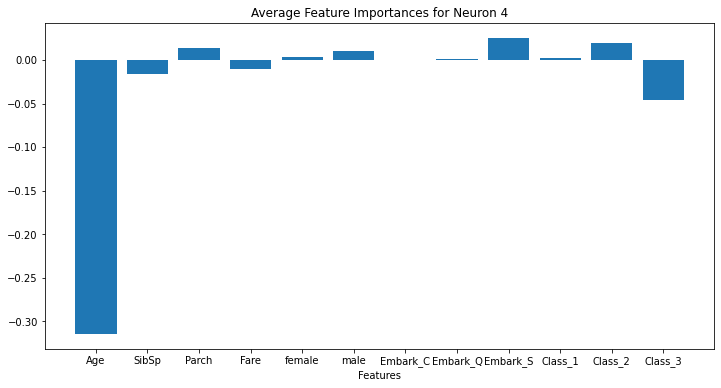

In [47]:
visualize_importances(feature_names, neuron_cond_vals_4.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 4")

De los datos anteriores, parece que la función de entrada principal utilizada por la neurona 4 es la edad, con una importancia limitada para todas las demás funciones.

Average Feature Importances for Neuron 6
Age :  -0.193
SibSp :  -0.019
Parch :  -0.025
Fare :  -0.014
female :  0.136
male :  -0.204
Embark_C :  0.015
Embark_Q :  0.014
Embark_S :  0.003
Class_1 :  0.065
Class_2 :  0.041
Class_3 :  -0.108


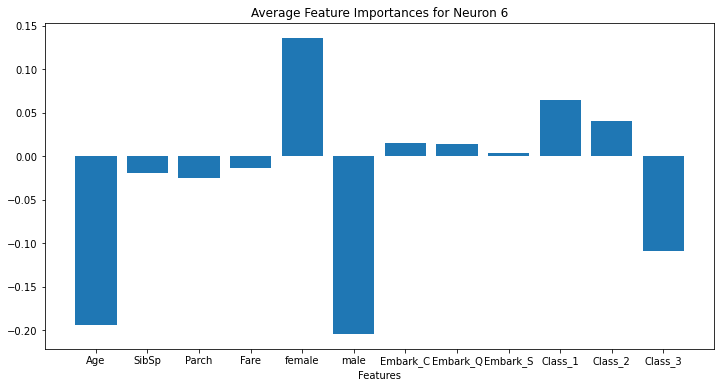

In [48]:
visualize_importances(feature_names, neuron_cond_vals_6.mean(dim=0).detach().numpy(), title="Average Feature Importances for Neuron 6")

De la visualización anterior vemos que la neurona 6 se basa principalmente en las características de género, edad y clase, muy diferentes del foco de la neurona 4.

Resumen

En esta demostración, hemos aplicado diferentes técnicas de atribución en Captum, incluidos los gradientes integrados para la atribución de funciones y la conductancia para la atribución de capas y neuronas, a fin de comprender mejor la red neuronal que predice la supervivencia. Aunque las redes más grandes son más difíciles de analizar que esta red simple, estos componentes básicos para la atribución se pueden utilizar para mejorar la interpretabilidad del modelo, rompiendo la caracterización tradicional de "caja negra" de las redes neuronales y profundizando en la comprensión de cómo y por qué hacen su trabajo. decisiones